# ***2.  Grouping Users together!***

Let's first import some libraries that might come in handy

In [1]:
!pip install pyspark #run just one time if you don't have pyspark installed

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=cff862c9b68094546dd98c4afa20bcc3fc589e8b4da2e9b7404d9b92e4d5e69c
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [2]:
from datetime import datetime, timedelta
from functools import reduce
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from pyspark.sql import SparkSession

import seaborn as sns #visualization library
import matplotlib.pyplot as plt

#basic data manipulation libraries
import pandas as pd
import numpy as np

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
file_path = '/content/drive/MyDrive/DATA SCIENCE 23 24/ADM /HMW4/archive/vodclickstream_uk_movies_03.csv'
dataset = pd.read_csv(file_path)
dataset
#the unnamed row is the row id

,Unnamed: 0,datetime,duration,title,genres,release_date,movie_id,user_id
0,58773,2017-01-01 01:15:09,0.0,"Angus, Thongs and Perfect Snogging","Comedy, Drama, Romance",2008-07-25,26bd5987e8,1dea19f6fe
1,58774,2017-01-01 13:56:02,0.0,The Curse of Sleeping Beauty,"Fantasy, Horror, Mystery, Thriller",2016-06-02,f26ed2675e,544dcbc510
2,58775,2017-01-01 15:17:47,10530.0,London Has Fallen,"Action, Thriller",2016-03-04,f77e500e7a,7cbcc791bf
3,58776,2017-01-01 16:04:13,49.0,Vendetta,"Action, Drama",2015-06-12,c74aec7673,ebf43c36b6
4,58777,2017-01-01 19:16:37,0.0,The SpongeBob SquarePants Movie,"Animation, Action, Adventure, Comedy, Family, ...",2004-11-19,a80d6fc2aa,a57c992287
...,...,...,...,...,...,...,...,...
671731,730504,2019-06-30 21:37:08,851.0,Oprah Presents When They See Us Now,Talk-Show,2019-06-12,43cd23f30f,57501964fd
671732,730505,2019-06-30 21:49:34,91157.0,HALO Legends,"Animation, Action, Adventure, Family, Sci-Fi",2010-02-16,febf42d55f,d4fcb079ba
671733,730506,2019-06-30 22:00:44,0.0,Pacific Rim,"Action, Adventure, Sci-Fi",2013-07-12,7b15e5ada1,4a14a2cd5a
671734,730507,2019-06-30 22:04:23,0.0,ReMastered: The Two Killings of Sam Cooke,"Documentary, Music",2019-02-08,52d49c515a,0b8163ea4b


In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 671736 entries, 0 to 671735
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    671736 non-null  int64  
 1   datetime      671736 non-null  object 
 2   duration      671736 non-null  float64
 3   title         671736 non-null  object 
 4   genres        671736 non-null  object 
 5   release_date  671736 non-null  object 
 6   movie_id      671736 non-null  object 
 7   user_id       671736 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 41.0+ MB


### ***Data preprocessing***

Before getting straight away into the analysis let's do some data preprocessing, that is an essential step in data mining that involves cleaning, transforming, and integrating raw data to make it ready for analysis.

In [6]:
#Let's see if we have duplicates
dataset = dataset.drop_duplicates()
dataset.info() #we don't have duplicates

<class 'pandas.core.frame.DataFrame'>
Int64Index: 671736 entries, 0 to 671735
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    671736 non-null  int64  
 1   datetime      671736 non-null  object 
 2   duration      671736 non-null  float64
 3   title         671736 non-null  object 
 4   genres        671736 non-null  object 
 5   release_date  671736 non-null  object 
 6   movie_id      671736 non-null  object 
 7   user_id       671736 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 46.1+ MB


> *Datetime and release_date*

In [7]:
#Since datetime and relase_date are "Objects" but need to be "datetime" we need to convert them:
dataset.datetime= pd.to_datetime(dataset.datetime, errors = "coerce")
dataset.datetime
#after analyzing the datetime values we noticed that there are some dates that are not proper dates, so we decide to convert those into NaT (NaN equivalent for datetime)
#with the parameter errors = "coerce

dataset.release_date = pd.to_datetime(dataset.release_date, errors = "coerce")
dataset.release_date

0        2008-07-25
1        2016-06-02
2        2016-03-04
3        2015-06-12
4        2004-11-19
            ...    
671731   2019-06-12
671732   2010-02-16
671733   2013-07-12
671734   2019-02-08
671735   2019-05-31
Name: release_date, Length: 671736, dtype: datetime64[ns]

In [8]:
#datetime
rows_with_NaN_datetime = dataset[dataset['datetime'].isna()]
rows_with_NaN_datetime
#we can see we have no NaN values

,Unnamed: 0,datetime,duration,title,genres,release_date,movie_id,user_id


In [9]:
#release_date
rows_with_NaN_release_date = dataset[dataset['release_date'].isna()]
rows_with_NaN_release_date
#from the ouput we can see there are 30304 NaT (equivalent of NaN) values for release_date, but we can also see that we have some NOT AVAILABLE values for the genres

,Unnamed: 0,datetime,duration,title,genres,release_date,movie_id,user_id
54,58827,2017-01-01 23:51:31,0.0,Minimalism: A Documentary About the Important ...,Documentary,NaT,4d5756f511,83e994b53d
64,58837,2017-01-01 23:18:10,81405.0,A Perfect Day,NOT AVAILABLE,NaT,9e898f41e0,8aff21d9e9
71,58844,2017-01-01 13:23:40,0.0,Minimalism: A Documentary About the Important ...,Documentary,NaT,4d5756f511,0b1635a78e
113,58886,2017-01-01 12:47:30,543.0,Hunting Britain's Most Wanted,NOT AVAILABLE,NaT,be096a4a5a,3cf91dd97e
118,58891,2017-01-01 17:20:26,0.0,Minimalism: A Documentary About the Important ...,Documentary,NaT,4d5756f511,ea05759d9b
...,...,...,...,...,...,...,...,...
671578,730351,2019-06-30 17:27:13,8272.0,Agatha Christie's Crooked House,NOT AVAILABLE,NaT,24e2aec1b8,75bfddddaf
671583,730356,2019-06-30 20:04:16,0.0,Den 12. mann,NOT AVAILABLE,NaT,8551a0dbdd,5c261da852
671643,730416,2019-06-30 17:14:14,0.0,Bad Moms,NOT AVAILABLE,NaT,934402ae13,06fb5a61d0
671708,730481,2019-06-30 21:10:44,3219.0,ReMastered: Who Shot the Sheriff,NOT AVAILABLE,NaT,d558d9be6f,0b8163ea4b


Let's go an see what happens with the "genres" column and if the 'NOT AVAILABLE' values are the same as the "release_date" NaT's

> *Genres*

In [10]:
dataset[dataset["genres"] == "NOT AVAILABLE"] #26561 rows

,Unnamed: 0,datetime,duration,title,genres,release_date,movie_id,user_id
38,58811,2017-01-01 22:59:43,0.0,Britain's Weirdest Phobias,NOT AVAILABLE,2009-01-06,43eb053a9a,5b935a9a3f
64,58837,2017-01-01 23:18:10,81405.0,A Perfect Day,NOT AVAILABLE,NaT,9e898f41e0,8aff21d9e9
113,58886,2017-01-01 12:47:30,543.0,Hunting Britain's Most Wanted,NOT AVAILABLE,NaT,be096a4a5a,3cf91dd97e
190,58963,2017-01-01 21:51:04,0.0,The Lion in Your Living Room,NOT AVAILABLE,NaT,86e19d79b2,614abddbe8
274,59047,2017-01-01 16:44:15,14.0,Puffin Rock: New Year's Eve Countdown,NOT AVAILABLE,NaT,d54e73d29b,9bada00eb3
...,...,...,...,...,...,...,...,...
671578,730351,2019-06-30 17:27:13,8272.0,Agatha Christie's Crooked House,NOT AVAILABLE,NaT,24e2aec1b8,75bfddddaf
671583,730356,2019-06-30 20:04:16,0.0,Den 12. mann,NOT AVAILABLE,NaT,8551a0dbdd,5c261da852
671643,730416,2019-06-30 17:14:14,0.0,Bad Moms,NOT AVAILABLE,NaT,934402ae13,06fb5a61d0
671708,730481,2019-06-30 21:10:44,3219.0,ReMastered: Who Shot the Sheriff,NOT AVAILABLE,NaT,d558d9be6f,0b8163ea4b


In [11]:
# Check if NaT of release_date is the same of NOT AVAILABLE of genre
assert (pd.isna(dataset['release_date']) == (dataset['genres'] == 'NOT AVAILABLE')).any()

# Get the boolean Series indicating whether a value is NaN in the 'release_date' column
nan_in_release_date = pd.isna(dataset['release_date'])

# Get the boolean Series indicating whether a value is 'NOT AVAILABLE' in the 'genres' column
not_available_in_genres = dataset['genres'] == 'NOT AVAILABLE'

# Get the boolean Series indicating whether both conditions are met
common_nan = nan_in_release_date & not_available_in_genres

# Count the number of common NaNs
count_common_nan = common_nan.sum()

print("Since the number of common NaNs is: " + str(count_common_nan) + " We decided to drop both the release_date NaT's and the 'NOT AVAILABLE' genres values.")
print("release_date and genres have a lot of NaT's and 'NOT AVAILABLE' values in common, so if we will drop them we won't loose that much data, just " + str(round((31894/671736)*100,1)) + "% of the dataset informations")


Since the number of common NaNs is: 24971 We decided to drop both the release_date NaT's and the 'NOT AVAILABLE' genres values.
release_date and genres have a lot of NaT's and 'NOT AVAILABLE' values in common, so if we will drop them we won't loose that much data, just 4.7% of the dataset informations


So now we are going to drop the NaT's and 'NOT AVAILABLE' and move on with our pre-processing:

In [12]:
genres_drop = dataset[dataset["genres"] == "NOT AVAILABLE"]
release_date_drop = dataset[dataset['release_date'].isna()]

In [13]:
#To drop the values we won't use the drop() function because we can't go back if we change idea
dataset = dataset[dataset["genres"] != "NOT AVAILABLE"]
dataset = dataset[dataset['release_date'].notna()]

In [14]:
dataset["genres"]
#we can see that the genre is a comma separated list of names

0                                    Comedy, Drama, Romance
1                        Fantasy, Horror, Mystery, Thriller
2                                          Action, Thriller
3                                             Action, Drama
4         Animation, Action, Adventure, Comedy, Family, ...
                                ...                        
671731                                            Talk-Show
671732         Animation, Action, Adventure, Family, Sci-Fi
671733                            Action, Adventure, Sci-Fi
671734                                   Documentary, Music
671735                                        Comedy, Drama
Name: genres, Length: 639842, dtype: object

In [15]:
#Since the genre is a comma separated list of names and not a list (that would be more helpful) we are going to convert it into a list
dataset["genres"] = dataset.genres.apply(lambda row : [word.strip() for word in row.split(",")]) #"strip" to remove spaces
dataset["genres"]

0                                  [Comedy, Drama, Romance]
1                      [Fantasy, Horror, Mystery, Thriller]
2                                        [Action, Thriller]
3                                           [Action, Drama]
4         [Animation, Action, Adventure, Comedy, Family,...
                                ...                        
671731                                          [Talk-Show]
671732       [Animation, Action, Adventure, Family, Sci-Fi]
671733                          [Action, Adventure, Sci-Fi]
671734                                 [Documentary, Music]
671735                                      [Comedy, Drama]
Name: genres, Length: 639842, dtype: object

In [16]:
unique_genres = reduce(lambda x, y : set(x).union(set(y)), dataset.genres)
unique_genres

{'Action',
 'Adventure',
 'Animation',
 'Biography',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Family',
 'Fantasy',
 'Film-Noir',
 'History',
 'Horror',
 'Music',
 'Musical',
 'Mystery',
 'News',
 'Reality-TV',
 'Romance',
 'Sci-Fi',
 'Short',
 'Sport',
 'Talk-Show',
 'Thriller',
 'War',
 'Western'}

We can see that we don't have the 'NOT AVAILABLE' value anymore

> *Duration* \\

In [17]:
#Ideally the duration column must have positive numbers, so let's check if there are any negative ones:
negative_values_exist = dataset[dataset['duration'] < 0]
negative_values_exist

,Unnamed: 0,datetime,duration,title,genres,release_date,movie_id,user_id
170,58943,2017-01-01 21:55:56,-1.0,Sneakerheadz,[Documentary],2015-08-07,452bb5938d,45620f32c1
177,58950,2017-01-01 15:05:12,-1.0,Of Mice and Men,"[Drama, Western]",1992-10-02,c6044ab412,312930eec8
196,58969,2017-01-01 01:32:36,-1.0,Mystic Pizza,"[Comedy, Drama, Romance]",1988-10-21,5c8f720a13,b0e816d681
243,59016,2017-01-01 16:32:58,-1.0,Eddie - Strongman,[Documentary],2015-08-08,9c6a96de04,010c9dcb45
277,59050,2017-01-01 20:17:35,-1.0,Sing Street,"[Comedy, Drama, Music, Romance]",2016-03-17,165109732c,b0c1e072f9
...,...,...,...,...,...,...,...,...
671627,730400,2019-06-30 19:18:33,-1.0,I Am Mother,"[Drama, Mystery, Sci-Fi, Thriller]",2019-06-07,74ef7aad7d,b88e481fd3
671629,730402,2019-06-30 20:25:08,-1.0,Beats,[Drama],2019-06-19,68fdb32f1e,bb532b24dd
671648,730421,2019-06-30 18:35:26,-1.0,The Emoji Movie,"[Animation, Adventure, Comedy, Family, Fantasy]",2017-07-28,66ccc3b2b5,1ecd36c319
671695,730468,2019-06-30 10:52:41,-1.0,Rough Night,"[Comedy, Crime, Thriller]",2017-06-16,a79079491a,5301342a0a


Remembering the dataset has 671736 rows and that the rows that correspond to the negative values are 21734 we can see that the proportion of negative values is really low compared to the whole length of the dataset, so we can delete them.

In [18]:
#We can see that we indeed have some negative values for the "duration" column, so let's keep the rows with just the >= 0 values:
mask = dataset['duration'] >= 0

# Use mask to filter out the rows with negative duration values
df_filtered = dataset[mask]
df_filtered #now this dataframe has only the positive duration values

,Unnamed: 0,datetime,duration,title,genres,release_date,movie_id,user_id
0,58773,2017-01-01 01:15:09,0.0,"Angus, Thongs and Perfect Snogging","[Comedy, Drama, Romance]",2008-07-25,26bd5987e8,1dea19f6fe
1,58774,2017-01-01 13:56:02,0.0,The Curse of Sleeping Beauty,"[Fantasy, Horror, Mystery, Thriller]",2016-06-02,f26ed2675e,544dcbc510
2,58775,2017-01-01 15:17:47,10530.0,London Has Fallen,"[Action, Thriller]",2016-03-04,f77e500e7a,7cbcc791bf
3,58776,2017-01-01 16:04:13,49.0,Vendetta,"[Action, Drama]",2015-06-12,c74aec7673,ebf43c36b6
4,58777,2017-01-01 19:16:37,0.0,The SpongeBob SquarePants Movie,"[Animation, Action, Adventure, Comedy, Family,...",2004-11-19,a80d6fc2aa,a57c992287
...,...,...,...,...,...,...,...,...
671731,730504,2019-06-30 21:37:08,851.0,Oprah Presents When They See Us Now,[Talk-Show],2019-06-12,43cd23f30f,57501964fd
671732,730505,2019-06-30 21:49:34,91157.0,HALO Legends,"[Animation, Action, Adventure, Family, Sci-Fi]",2010-02-16,febf42d55f,d4fcb079ba
671733,730506,2019-06-30 22:00:44,0.0,Pacific Rim,"[Action, Adventure, Sci-Fi]",2013-07-12,7b15e5ada1,4a14a2cd5a
671734,730507,2019-06-30 22:04:23,0.0,ReMastered: The Two Killings of Sam Cooke,"[Documentary, Music]",2019-02-08,52d49c515a,0b8163ea4b


with this further deletion the percentage of deleted data goes up to 8%, which is not that much.

> *Title* \\
Now let's see if we have any strange values in the "title" column

In [19]:
#As a first thin we check for empty strings "[]"
rows_with_empty_list = df_filtered[df_filtered['title'].apply(lambda x: x == [])]
rows_with_empty_list
#we can see that we don't have any empty string as an entry for the "title column"

,Unnamed: 0,datetime,duration,title,genres,release_date,movie_id,user_id


In [20]:
#Then we check for NaN values
rows_with_NaN = df_filtered[df_filtered['title'].isna()]
rows_with_NaN
##we can see that we don't have any Nan values either

,Unnamed: 0,datetime,duration,title,genres,release_date,movie_id,user_id


### ***2.1 -  Getting your data + feature engineering***

> After having a look at the dataset we will group the data by user_id to get the new following suggested features:

> a) **Favorite genre** (i.e., the genre on which the user spent the most time)

> b) **Average click duration**

> c) **Time of the day** (Morning/Afternoon/Night) when the user spends the most time on the platform (the time spent is tracked through the duration of the clicks)

> d) Is the user an old **movie lover, or is he into more recent stuff** (content released after 2010)?

> e) **Average time spent a day by the user** (considering only the days he logs in)

In [21]:
#For this question we are going to work with the users, so we need to group by "user_id"
df_filtered.groupby(by = "user_id")

***Favorite genre***

In [22]:
# Create a new DataFrame with a row for each item in the 'genres_list' column
df_genres = df_filtered.explode("genres").reset_index(drop=True)

# Group by 'user_id' and 'genres_list' to get the sum of 'duration' for each combination
genre_duration = df_genres.groupby(["user_id", "genres"])["duration"].sum().reset_index()

# Find the favorite genre by getting the row with the maximum 'duration' for each 'user_id'
favorite_genre = genre_duration.loc[genre_duration.groupby("user_id")["duration"].idxmax()]

In [23]:
# Rename the column "genres" to "favorite_genre"
favorite_genre = favorite_genre.rename(columns={"genres": "favorite_genre"})
favorite_genre

,user_id,favorite_genre,duration
0,00004e2862,Crime,0.0
3,000052a0a0,Action,37270.0
17,000090e7c8,Mystery,0.0
20,000118a755,Horror,0.0
21,000296842d,Drama,77308.0
...,...,...,...
806074,fffd9bf758,Crime,8495.0
806077,fffe7b777b,Drama,1785.0
806084,fffeac83be,Drama,355099.0
806089,ffff2c5f9e,Action,0.0


***Average click duration***

In [24]:
df = pd.DataFrame()
df["average_click_duration"] = df_filtered.groupby("user_id").duration.mean()
df["average_click_duration"]

user_id
00004e2862        0.000000
000052a0a0     2024.166667
000090e7c8        0.000000
000118a755        0.000000
000296842d    11044.000000
                  ...     
fffd9bf758     8495.000000
fffe7b777b     1785.000000
fffeac83be    40606.272727
ffff2c5f9e        0.000000
ffffd36adf        0.000000
Name: average_click_duration, Length: 150291, dtype: float64

***Time of the day***

In [25]:
df_filtered["hourofday"] = 0
df_filtered["hourofday"] = df_filtered.datetime.dt.hour

#Now let's extract the max
max_ = df_filtered.groupby(by = ["user_id", "hourofday"]).duration.mean().reset_index()

cols = ["user_id", "hourofday"]
max_time_of_day = max_.sort_values(cols, ascending = [True, False]).groupby("user_id", as_index = False).first()
max_time_of_day

def time_of_day_category(hour):
    if hour < 12:
        return 'Morning'
    elif hour < 18:
        return 'Afternoon'
    else:
        return 'Night'

max_time_of_day['time_of_day_category'] = max_time_of_day['hourofday'].apply(time_of_day_category)
max_time_of_day

<ipython-input-25-78972fb128ee>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["hourofday"] = 0
<ipython-input-25-78972fb128ee>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["hourofday"] = df_filtered.datetime.dt.hour


,user_id,hourofday,duration,time_of_day_category
0,00004e2862,20,0.000000,Night
1,000052a0a0,23,1988.000000,Night
2,000090e7c8,20,0.000000,Night
3,000118a755,23,0.000000,Night
4,000296842d,22,6470.500000,Night
...,...,...,...,...
150286,fffd9bf758,18,8495.000000,Night
150287,fffe7b777b,17,1785.000000,Afternoon
150288,fffeac83be,21,50384.857143,Night
150289,ffff2c5f9e,15,0.000000,Afternoon


***Old/ New school user***

In [26]:
df_filtered["oldmovie_lover"] = False
df_filtered["oldmovie_lover"] = df_filtered.release_date.dt.year < 2010

#counts the number of movies watched by each user for each movie preference category (True = old movies, False = new movies)
df_unsorted = df_filtered.groupby(by = ["user_id", "oldmovie_lover"])["movie_id"].count().reset_index()
df_oldnew = df_unsorted.sort_values(["user_id", "oldmovie_lover"], ascending = [True, False]).groupby("user_id", as_index = False).first()

df_oldnew

<ipython-input-26-a6f1b98480a9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["oldmovie_lover"] = False
<ipython-input-26-a6f1b98480a9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["oldmovie_lover"] = df_filtered.release_date.dt.year < 2010


,user_id,oldmovie_lover,movie_id
0,00004e2862,True,1
1,000052a0a0,True,9
2,000090e7c8,False,1
3,000118a755,True,1
4,000296842d,False,7
...,...,...,...
150286,fffd9bf758,False,1
150287,fffe7b777b,False,1
150288,fffeac83be,True,2
150289,ffff2c5f9e,True,1


In this newly created dataframe 'df_oldnew' the users are sorted by their movie preferences. For each user, if their "oldmovie_lover" value is True it means they prefer older movies, if their "oldmovie_lover" value is False it means they prefer more recent movies.

**Average time spent a day by the user** (considering only the days he logs in)

In [27]:
# Calculate the total duration spent by the user per day
# Extract the date from the datetime column
df_filtered['date'] = df_filtered['datetime'].dt.date

# Compute the total duration of the movies each user watched
total_duration = df_filtered.groupby("user_id")["duration"].sum().reset_index()

# Compute the number of unique days each user logged in
days_logged_in = df_filtered.groupby("user_id")["date"].nunique().reset_index()

# Compute the average duration per day by dividing the total duration by the number of unique days logged in
average_duration_per_day = total_duration.merge(days_logged_in, on="user_id")
average_duration_per_day['average_duration_per_day'] = average_duration_per_day['duration'] / average_duration_per_day['date']

average_duration_per_day

<ipython-input-27-2245445c4d93>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['date'] = df_filtered['datetime'].dt.date


,user_id,duration,date,average_duration_per_day
0,00004e2862,0.0,1,0.000
1,000052a0a0,48580.0,10,4858.000
2,000090e7c8,0.0,1,0.000
3,000118a755,0.0,1,0.000
4,000296842d,77308.0,2,38654.000
...,...,...,...,...
150286,fffd9bf758,8495.0,1,8495.000
150287,fffe7b777b,1785.0,1,1785.000
150288,fffeac83be,446669.0,8,55833.625
150289,ffff2c5f9e,0.0,1,0.000


Now let's merge the dataframes that contain the 5 suggested features:

In [28]:
df_5_features = favorite_genre[["user_id",	"favorite_genre"]].merge(max_time_of_day[["user_id","time_of_day_category"]], on = "user_id", how = "inner").merge(df["average_click_duration"], on = "user_id", how = "inner").merge(df_oldnew[["user_id", "oldmovie_lover"]], on = "user_id", how = "inner").merge(average_duration_per_day[["user_id", "average_duration_per_day"]],on = "user_id", how = "inner")
df_5_features

,user_id,favorite_genre,time_of_day_category,average_click_duration,oldmovie_lover,average_duration_per_day
0,00004e2862,Crime,Night,0.000000,True,0.000
1,000052a0a0,Action,Night,2024.166667,True,4858.000
2,000090e7c8,Mystery,Night,0.000000,False,0.000
3,000118a755,Horror,Night,0.000000,True,0.000
4,000296842d,Drama,Night,11044.000000,False,38654.000
...,...,...,...,...,...,...
150286,fffd9bf758,Crime,Night,8495.000000,False,8495.000
150287,fffe7b777b,Drama,Afternoon,1785.000000,False,1785.000
150288,fffeac83be,Drama,Night,40606.272727,True,55833.625
150289,ffff2c5f9e,Action,Afternoon,0.000000,True,0.000


Blackbox AI and Phind suggested the following additional features: \\
1. ***Total Number of Movies Watched***: This can be calculated by counting the number of unique movie_ids associated with a user_id.

2. ***User's Most Watched Movie*** *(with movie title)*: This can be determined by grouping the data by 'user_id' and 'movie_id', and then finding the movie with the highest count for each user.

3. ***User's Most Watched Month***: This can be determined by extracting the month from the 'datetime' column, grouping the data by 'user_id' and 'month', and then finding the month with the highest count for each user.

4. ***User frequency***

5. ***User recency***

6. ***Number of days***: Calculate the number of distinct days when the user has watched movies.

7. ***Average movie release year***: Average release year of the movies each user has watched. This can be done by converting the 'release_date' to datetime, extracting the year, and then calculating the mean.

8. ***Number of movies watched per day***: If the 'datetime' column contains the date of watching, you can count the number of movies each user has watched each day. This can be done by grouping the data by 'user_id' and 'datetime', and then counting the number of occurrences of each date.

9. ***Maximum time spent watching a movie***: Find the maximum time duration spent watching a movie by each user.

10. User's ***Most Frequent Day of the Week***: This feature can be computed by extracting the day of the week from the 'datetime' column, grouping the data by 'user_id' and 'day_of_week', and then finding the day with the highest count for each user.


The **user frequency** represents the number of times a user has interacted with your product or service. For example, if a user_id has interacted with your website 10 times, then their user frequency is 10.

The **user recency** represents the most recent date on which a user interacted with your product or service. For example, if a user_id last interacted with your website on '2021-03-05', then their user recency is '2021-03-05'.

Both user frequency and recency are important metrics to evaluate the behavior of your users. By analyzing these metrics, you can gain insights into your users' preferences, behavior patterns, and potential areas for improvement.

In [29]:
#Let's initalize a dataframe where we will put all the new featires
df_2 =pd.DataFrame()

In [30]:
#1
df_2["tot_movie_watched"] = df_filtered.groupby('user_id')['movie_id'].nunique()
df_2

,tot_movie_watched
user_id,
00004e2862,1
000052a0a0,11
000090e7c8,1
000118a755,1
000296842d,1
...,...
fffd9bf758,1
fffe7b777b,1
fffeac83be,10


In [31]:
#2 User's most watched movie (with title)
most_watched_movie = df_filtered.groupby('user_id')['title'].agg(lambda x: x.value_counts().idxmax())
most_watched_movie

df_2["most_watched_movie"] = most_watched_movie
df_2

,tot_movie_watched,most_watched_movie
user_id,,
00004e2862,1,Hannibal
000052a0a0,11,Looper
000090e7c8,1,Mute
000118a755,1,The Omen
000296842d,1,Black Mirror: Bandersnatch
...,...,...
fffd9bf758,1,The Fear of 13
fffe7b777b,1,The Circle
fffeac83be,10,Amanda Knox


In [32]:
#3 User's most watched month
df_filtered["month"] = df_filtered["datetime"].dt.month
most_watched_month = df_filtered.groupby("user_id")["month"].agg(lambda x: x.value_counts().idxmax())
most_watched_month

df_2["most_watched_month"]= most_watched_month
df_2

<ipython-input-32-5a609e66b596>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["month"] = df_filtered["datetime"].dt.month


,tot_movie_watched,most_watched_movie,most_watched_month
user_id,,,
00004e2862,1,Hannibal,12
000052a0a0,11,Looper,6
000090e7c8,1,Mute,3
000118a755,1,The Omen,6
000296842d,1,Black Mirror: Bandersnatch,12
...,...,...,...
fffd9bf758,1,The Fear of 13,6
fffe7b777b,1,The Circle,8
fffeac83be,10,Amanda Knox,8


In [33]:
#4
# Calculate user frequency
grouped = df_filtered.groupby("user_id").size().reset_index(name="frequency")
grouped

,user_id,frequency
0,00004e2862,1
1,000052a0a0,24
2,000090e7c8,1
3,000118a755,1
4,000296842d,7
...,...,...
150286,fffd9bf758,1
150287,fffe7b777b,1
150288,fffeac83be,11
150289,ffff2c5f9e,2


In [34]:
#5
#Calculate user recency
df_filtered["datetime"] = pd.to_datetime(df_filtered["datetime"]) # Ensure the timestamp column is in datetime format
grouped["recency"] = df_filtered.groupby("user_id")["datetime"].max().reset_index(name="recency")["recency"]
grouped
# grouped is now a dataframe where each row represents a user_id and the frequency and recency columns contain the frequency and recency of each user_id.

<ipython-input-34-aaf73a957085>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["datetime"] = pd.to_datetime(df_filtered["datetime"]) # Ensure the timestamp column is in datetime format


,user_id,frequency,recency
0,00004e2862,1,2017-12-05 20:39:15
1,000052a0a0,24,2017-06-26 18:25:42
2,000090e7c8,1,2018-03-09 20:01:40
3,000118a755,1,2018-06-14 23:19:33
4,000296842d,7,2018-12-31 20:06:23
...,...,...,...
150286,fffd9bf758,1,2017-06-21 18:06:32
150287,fffe7b777b,1,2017-08-19 17:03:18
150288,fffeac83be,11,2017-09-20 21:18:18
150289,ffff2c5f9e,2,2017-07-23 15:02:43


In [35]:
#6
df_2["num_of_days"] = df_filtered.groupby("user_id")["datetime"].nunique()
df_2

,tot_movie_watched,most_watched_movie,most_watched_month,num_of_days
user_id,,,,
00004e2862,1,Hannibal,12,1
000052a0a0,11,Looper,6,18
000090e7c8,1,Mute,3,1
000118a755,1,The Omen,6,1
000296842d,1,Black Mirror: Bandersnatch,12,4
...,...,...,...,...
fffd9bf758,1,The Fear of 13,6,1
fffe7b777b,1,The Circle,8,1
fffeac83be,10,Amanda Knox,8,11


In [36]:
#7
df_filtered['release_year'] = df_filtered['release_date'].dt.year
average_release_year = df_filtered.groupby('user_id')['release_year'].mean()
average_release_year = round(average_release_year, 0).astype("int64")
average_release_year

<ipython-input-36-876b223d5fe2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['release_year'] = df_filtered['release_date'].dt.year


user_id
00004e2862    2001
000052a0a0    2008
000090e7c8    2018
000118a755    1976
000296842d    2018
              ... 
fffd9bf758    2015
fffe7b777b    2017
fffeac83be    2012
ffff2c5f9e    2010
ffffd36adf    1996
Name: release_year, Length: 150291, dtype: int64

In [37]:
df_2["average_release_year"] = average_release_year
df_2

,tot_movie_watched,most_watched_movie,most_watched_month,num_of_days,average_release_year
user_id,,,,,
00004e2862,1,Hannibal,12,1,2001
000052a0a0,11,Looper,6,18,2008
000090e7c8,1,Mute,3,1,2018
000118a755,1,The Omen,6,1,1976
000296842d,1,Black Mirror: Bandersnatch,12,4,2018
...,...,...,...,...,...
fffd9bf758,1,The Fear of 13,6,1,2015
fffe7b777b,1,The Circle,8,1,2017
fffeac83be,10,Amanda Knox,8,11,2012


In [38]:
#8
df_filtered['is_weekend'] = df_filtered['datetime'].dt.weekday >= 5
weekend_clicks = df_filtered[df_filtered['is_weekend']]
average_weekend_click_duration = weekend_clicks.groupby('user_id')['duration'].mean()
average_weekend_click_duration

<ipython-input-38-b835de7115a1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['is_weekend'] = df_filtered['datetime'].dt.weekday >= 5


user_id
000052a0a0       885.000000
000296842d      6470.500000
0002aab109     41812.500000
0006b97ace    134824.000000
0006ea6b5c      1542.857143
                  ...      
fffc1d209b      5443.500000
fffe7b777b      1785.000000
fffeac83be      3385.000000
ffff2c5f9e         0.000000
ffffd36adf         0.000000
Name: duration, Length: 82381, dtype: float64

In [39]:
average_weekend_click_duration_df = average_weekend_click_duration.reset_index()
average_weekend_click_duration_df.rename(columns={'duration': 'average_weekend_click_duration'}, inplace=True)
average_weekend_click_duration_df

,user_id,average_weekend_click_duration
0,000052a0a0,885.000000
1,000296842d,6470.500000
2,0002aab109,41812.500000
3,0006b97ace,134824.000000
4,0006ea6b5c,1542.857143
...,...,...
82376,fffc1d209b,5443.500000
82377,fffe7b777b,1785.000000
82378,fffeac83be,3385.000000
82379,ffff2c5f9e,0.000000


In [40]:
#9
df_2["max_time_spent_watching"] = df_filtered.groupby("user_id")["duration"].max()
df_2

,tot_movie_watched,most_watched_movie,most_watched_month,num_of_days,average_release_year,max_time_spent_watching
user_id,,,,,,
00004e2862,1,Hannibal,12,1,2001,0.0
000052a0a0,11,Looper,6,18,2008,7857.0
000090e7c8,1,Mute,3,1,2018,0.0
000118a755,1,The Omen,6,1,1976,0.0
000296842d,1,Black Mirror: Bandersnatch,12,4,2018,62860.0
...,...,...,...,...,...,...
fffd9bf758,1,The Fear of 13,6,1,2015,8495.0
fffe7b777b,1,The Circle,8,1,2017,1785.0
fffeac83be,10,Amanda Knox,8,11,2012,173436.0


In [41]:
#10
#Day of the week
df_filtered['day_of_week'] = df_filtered['datetime'].dt.day_name()

# Group by 'user_id' and 'day_of_week' and find the most frequent day for each user
most_frequent_day = df_filtered.groupby(['user_id', 'day_of_week']).size().groupby('user_id').idxmax()
most_frequent_day

<ipython-input-41-6f3c0b0efdbf>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['day_of_week'] = df_filtered['datetime'].dt.day_name()


user_id
00004e2862      (00004e2862, Tuesday)
000052a0a0       (000052a0a0, Sunday)
000090e7c8       (000090e7c8, Friday)
000118a755     (000118a755, Thursday)
000296842d       (000296842d, Monday)
                       ...           
fffd9bf758    (fffd9bf758, Wednesday)
fffe7b777b     (fffe7b777b, Saturday)
fffeac83be    (fffeac83be, Wednesday)
ffff2c5f9e       (ffff2c5f9e, Sunday)
ffffd36adf     (ffffd36adf, Saturday)
Length: 150291, dtype: object

In [42]:
#Extracting the day of the week
days_of_week = [t[1] for t in most_frequent_day]
df_2["most_frequent_day"] = days_of_week
df_2

,tot_movie_watched,most_watched_movie,most_watched_month,num_of_days,average_release_year,max_time_spent_watching,most_frequent_day
user_id,,,,,,,
00004e2862,1,Hannibal,12,1,2001,0.0,Tuesday
000052a0a0,11,Looper,6,18,2008,7857.0,Sunday
000090e7c8,1,Mute,3,1,2018,0.0,Friday
000118a755,1,The Omen,6,1,1976,0.0,Thursday
000296842d,1,Black Mirror: Bandersnatch,12,4,2018,62860.0,Monday
...,...,...,...,...,...,...,...
fffd9bf758,1,The Fear of 13,6,1,2015,8495.0,Wednesday
fffe7b777b,1,The Circle,8,1,2017,1785.0,Saturday
fffeac83be,10,Amanda Knox,8,11,2012,173436.0,Wednesday


After creating this additional features we can put them in a dataframe and merge it on the "*user_id*" column with the dataframe composed by the 5 previuosly suggested features. \\
We will now have the final dataframe with 15 features for each user:

In [43]:
final_df = df_5_features.merge(df_2, on = "user_id" , how ="inner").merge(grouped, on = "user_id", how = "inner").merge(average_weekend_click_duration_df[["user_id", "average_weekend_click_duration"]], on = "user_id", how = "inner")
final_df

,user_id,favorite_genre,time_of_day_category,average_click_duration,oldmovie_lover,average_duration_per_day,tot_movie_watched,most_watched_movie,most_watched_month,num_of_days,average_release_year,max_time_spent_watching,most_frequent_day,frequency,recency,average_weekend_click_duration
0,000052a0a0,Action,Night,2024.166667,True,4858.000000,11,Looper,6,18,2008,7857.0,Sunday,24,2017-06-26 18:25:42,885.000000
1,000296842d,Drama,Night,11044.000000,False,38654.000000,1,Black Mirror: Bandersnatch,12,4,2018,62860.0,Monday,7,2018-12-31 20:06:23,6470.500000
2,0002aab109,Biography,Night,27875.000000,False,27875.000000,3,King Cobra,5,3,2013,83625.0,Saturday,3,2017-05-07 20:36:52,41812.500000
3,0006b97ace,Horror,Night,134824.000000,False,134824.000000,1,Insidious,2,1,2011,134824.0,Saturday,1,2017-02-11 20:42:50,134824.000000
4,0006ea6b5c,Comedy,Night,1120.866667,True,1401.083333,14,Dragon Blade,6,15,2014,4831.0,Friday,15,2017-06-29 00:05:28,1542.857143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82376,fffc1d209b,Action,Night,20611.600000,False,51529.000000,6,R.I.P.D.,4,9,2014,89233.0,Friday,10,2018-04-14 16:34:50,5443.500000
82377,fffe7b777b,Drama,Afternoon,1785.000000,False,1785.000000,1,The Circle,8,1,2017,1785.0,Saturday,1,2017-08-19 17:03:18,1785.000000
82378,fffeac83be,Drama,Night,40606.272727,True,55833.625000,10,Amanda Knox,8,11,2012,173436.0,Wednesday,11,2017-09-20 21:18:18,3385.000000
82379,ffff2c5f9e,Action,Afternoon,0.000000,True,0.000000,2,Forks Over Knives,7,2,2010,0.0,Sunday,2,2017-07-23 15:02:43,0.000000


In [44]:
final_df.isna().sum()

user_id                           0
favorite_genre                    0
time_of_day_category              0
average_click_duration            0
oldmovie_lover                    0
average_duration_per_day          0
tot_movie_watched                 0
most_watched_movie                0
most_watched_month                0
num_of_days                       0
average_release_year              0
max_time_spent_watching           0
most_frequent_day                 0
frequency                         0
recency                           0
average_weekend_click_duration    0
dtype: int64

In [45]:
#To save memory and to avoid havein to re-run eveything we can save this dataframe into a .csv file
final_df.to_csv("final.csv", index=False)

### ***2.2 - Choose your features (variables)!***

##### ***2.2.1***

Normalization is generally used when the features are measured in different units or when they vary in range. It can also be beneficial when dealing with algorithms that use distance measures like the K-Nearest Neighbors (KNN). \\
The decision to normalize or not to normalize the features, though, depends on the nature of the data and the machine learning algorithm used. It also has to be taken into account that normalization does not apply to categorical features (we have 6 of them), and that sometimes it might lead to loss of information, especially for features with outliers.

\\
Since before proceeding with the required tasks we did data preprocessing we shouldn't have problems with outliears or NaN/strange values in our dataset, and it's actually reccomended to normalize since we are going to use machine learning algorithms later on, and many of them assume that all featured are centered around zero and have a variance of the same order.

To perform normalization on the numerical variables of the dataset, we can use the StandardScaler class from the sklearn.preprocessing module. This class scales and translates each feature individually such that it is in the given range on the training set, typically between zero and one.

In [92]:
final_df = pd.read_csv("final.csv")

In [47]:
numerical_columns = ['average_click_duration', 'average_duration_per_day', 'tot_movie_watched', 'num_of_days', 'average_release_year', 'max_time_spent_watching', 'frequency', 'average_weekend_click_duration']

# Initialize the MinMaxScaler
scaler = StandardScaler()

# Fit and transform the data
final_df_normalized = pd.DataFrame(scaler.fit_transform(final_df[numerical_columns]), columns=numerical_columns)

In [48]:
#Now let's have a look at a couple of statistical summaries of the new normalized dataframe
final_df_normalized.describe()

,average_click_duration,average_duration_per_day,tot_movie_watched,num_of_days,average_release_year,max_time_spent_watching,frequency,average_weekend_click_duration
count,8.238100e+04,8.238100e+04,8.238100e+04,8.238100e+04,8.238100e+04,8.238100e+04,8.238100e+04,8.238100e+04
mean,1.742266e-17,-3.639784e-17,-7.298974e-18,-2.774041e-17,9.970571e-15,-8.538829e-18,6.939955e-17,-1.423138e-17
std,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00,1.000006e+00
min,-2.972697e-01,-3.367563e-01,-5.935210e-01,-5.540967e-01,-1.118753e+01,-4.213617e-01,-5.661692e-01,-2.604747e-01
25%,-2.965242e-01,-3.357205e-01,-5.935210e-01,-5.540967e-01,-2.904750e-01,-4.204800e-01,-4.442734e-01,-2.604747e-01
50%,-2.542976e-01,-2.798050e-01,-4.033286e-01,-2.964534e-01,3.322138e-01,-3.632465e-01,-3.223777e-01,-2.457532e-01
75%,-8.163873e-02,-6.342716e-02,1.672486e-01,9.001141e-02,6.435582e-01,-5.858685e-02,1.652054e-01,-1.350782e-01
max,6.123498e+01,5.206296e+01,3.839592e+01,9.245511e+01,1.266247e+00,2.953630e+01,8.744257e+01,5.232400e+01


From the summary statistics we can see that we actually scaled the numerical variables to be with meand around 0 and variance around 1. They're now ready to be fed into whatever machine learning algorithm we are going to use.

##### ***2.2.2***

Principal Component Analysis (PCA) is a widely used method for dimensionality reduction that allows us to reduce the dimensionality of our data without losing too much information. This is achieved by transforming the original data into a new coordinate system where the first few principal components (which are linear combinations of the original features) have the highest variance. This helps to capture the most significant aspects of the data while reducing the dimensionality.

PCA is particularly useful when dealing with high-dimensional data, as it can help to simplify the data while preserving as much of the variance as possible. This can make the data easier to visualize and analyze, and it can also improve the performance of machine learning algorithms by reducing the computational complexity.

However, it's important to note that PCA has some limitations:
1. It assumes that the data is centered around the mean (zero mean) and has a variance of one (unit variance), which can be achieved using data standardization. However, if these assumptions are not met, the results of PCA may not be accurate.

2. Additionally, PCA is not suitable for datasets with missing values or categorical data. The interpretation of the components may be complex in some cases, particularly when dealing with high-dimensional data. PCA is not designed to address multicollinearity, and the correlation among the components may not accurately reflect the correlation among the original variables.

3. Finally, PCA does not guarantee a monotonic increase in the explained variance, meaning that the proportion of variance explained by successive components may decrease. In such cases, it is difficult to determine the optimal number of components.

Despite these limitations, PCA remains a powerful technique for dimensionality reduction and data exploration.

To meet the assumptions for the PCA we normalized the data and we will use one-hot encoding to deal with the categorical variables. \\
One-hot encoding is a technique used to convert categorical data into a format that can be used by machine learning algorithms. In this process, each unique category in the categorical variable is assigned a binary vector. \\
However, it's important to note that one-hot encoding can significantly increase the dimensionality of the data if the categorical variable has many categories. This can make PCA less effective, as it may not be able to capture the variance in the data due to the high dimensionality.

> The 'recency' categorical variable is made up of a date plus a timestamp: \\
(e.g.) 2017-06-26 18:25:42 \\
Since the output of the one-hot encoding on this will result in
a giant matrix, performing the PCA with this variable plus all the others will make Colab explode, which will happen also if we exclude it. \\
We also tried to include variuos combinations of the categorical variables, plus the numerical ones, and obtained the following results:

| Categorical variables included | Number of Principal Components | Explaiend variance |
|---------|:---------:|:---------:|
| favorite_genre | 5| 90% |
| favorite_genre, oldmovie_lover, most_frequent_day | 3 | 76% |
| favorite_genre, oldmovie_lover, most_frequent_day, most_watched_month | 3 | 69% |
| favorite_genre, oldmovie_lover, most_frequent_day, most_watched_month, most_watched_movie | 3 | 67% |

> We can see that adding further categorical variables after "favorite_genre" makes both the explained variance and the number of components decrease. \\The latter is good, because it means we can succesfully reduce the dimentionality, but the former is not really good because we go from 90% of explained variance to just 67%.


After performing the PCA in all fo this cases we came to the conclusion that we have better performance when we include only the numerical variables that are in the "final_df_normalized". We will get 92% of explained variance with 3 principal components:

In [49]:
#In Python, you can use the "get_dummies" function in pandas to perform one-hot encoding
categorical_columns = ['favorite_genre', 'time_of_day_category', 'oldmovie_lover', 'most_watched_movie', 'most_watched_month', 'most_frequent_day']

# Apply one-hot encoding
df_encoded = pd.get_dummies(final_df, columns=categorical_columns)
df_encoded.head(5)

,user_id,average_click_duration,average_duration_per_day,tot_movie_watched,num_of_days,average_release_year,max_time_spent_watching,frequency,recency,average_weekend_click_duration,...,most_watched_month_10,most_watched_month_11,most_watched_month_12,most_frequent_day_Friday,most_frequent_day_Monday,most_frequent_day_Saturday,most_frequent_day_Sunday,most_frequent_day_Thursday,most_frequent_day_Tuesday,most_frequent_day_Wednesday
0,000052a0a0,2024.166667,4858.000000,11,18,2008,7857.0,24,2017-06-26 18:25:42,885.000000,...,0,0,0,0,0,0,1,0,0,0
1,000296842d,11044.000000,38654.000000,1,4,2018,62860.0,7,2018-12-31 20:06:23,6470.500000,...,0,0,1,0,1,0,0,0,0,0
2,0002aab109,27875.000000,27875.000000,3,3,2013,83625.0,3,2017-05-07 20:36:52,41812.500000,...,0,0,0,0,0,1,0,0,0,0
3,0006b97ace,134824.000000,134824.000000,1,1,2011,134824.0,1,2017-02-11 20:42:50,134824.000000,...,0,0,0,0,0,1,0,0,0,0
4,0006ea6b5c,1120.866667,1401.083333,14,15,2014,4831.0,15,2017-06-29 00:05:28,1542.857143,...,0,0,0,1,0,0,0,0,0,0


In [50]:
#Let's drop both the 'recency' and the numerical columns from the df_encoded because they are normalized in the final_df_normalized
numerical_columns = ['average_click_duration', 'average_duration_per_day', 'tot_movie_watched', 'num_of_days', 'average_release_year', 'max_time_spent_watching', 'frequency', 'recency', 'average_weekend_click_duration']
df_encoded = df_encoded.drop(columns=numerical_columns)

#Concatenate the DataFrames to get together the normalized numerical columns and the one-hot encoded to have a dataframe to perform the PCA on
df_encoded_normalized = pd.concat([df_encoded, final_df_normalized], axis=1)
df_encoded_normalized = df_encoded_normalized.drop("user_id", axis = 1)
df_encoded_normalized

,favorite_genre_Action,favorite_genre_Adventure,favorite_genre_Animation,favorite_genre_Biography,favorite_genre_Comedy,favorite_genre_Crime,favorite_genre_Documentary,favorite_genre_Drama,favorite_genre_Family,favorite_genre_Fantasy,...,most_frequent_day_Tuesday,most_frequent_day_Wednesday,average_click_duration,average_duration_per_day,tot_movie_watched,num_of_days,average_release_year,max_time_spent_watching,frequency,average_weekend_click_duration
0,1,0,0,0,0,0,0,0,0,0,...,0,0,-0.283592,-0.308802,1.308403,1.635871,-0.601819,-0.395513,2.237433,-0.255364
1,0,0,0,0,0,0,0,1,0,0,...,0,0,-0.222643,-0.114327,-0.593521,-0.167632,0.954903,-0.214562,0.165205,-0.223110
2,0,0,0,1,0,0,0,0,0,0,...,0,0,-0.108911,-0.176354,-0.213136,-0.296453,0.176542,-0.146248,-0.322378,-0.019022
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0.613771,0.439069,-0.593521,-0.554097,-0.134803,0.022189,-0.566169,0.518086
4,0,0,0,0,1,0,0,0,0,0,...,0,0,-0.289696,-0.328694,1.878980,1.249406,0.332214,-0.405468,1.140371,-0.251565
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82376,1,0,0,0,0,0,0,0,0,0,...,0,0,-0.157992,-0.040240,0.357441,0.476476,0.332214,-0.127799,0.530893,-0.229040
82377,0,0,0,0,0,0,0,1,0,0,...,0,0,-0.285208,-0.326485,-0.593521,-0.554097,0.799230,-0.415489,-0.566169,-0.250167
82378,0,0,0,0,0,0,0,1,0,0,...,0,1,-0.022882,-0.015470,1.118211,0.734119,0.020869,0.149216,0.652788,-0.240927
82379,1,0,0,0,0,0,0,0,0,0,...,0,0,-0.297270,-0.336756,-0.403329,-0.425275,-0.290475,-0.421362,-0.444273,-0.260475


Let's get on with the Principal Component Analysis (PCA) that will allow us to perform dimensionality reduction on our data without losing too much information.

> As the first step we will use the elbow method to find the optimal number of principal components to keep. \\
The elbow method is a technique used to determine the optimal number of components in Principal Component Analysis (PCA). It is a method that involves plotting the explained variance as a function of the number of components and identifying the point where the curve begins to bend, often referred to as the "elbow" of the curve. This point is typically chosen as the optimal number of components to retain, as adding more components does not significantly increase the explained variance.

In other words, the elbow method helps to find the right balance between the reduction in dimensionality and the loss of information. It's a practical and effective way to determine the number of principal components that capture the most significant variance in the data.

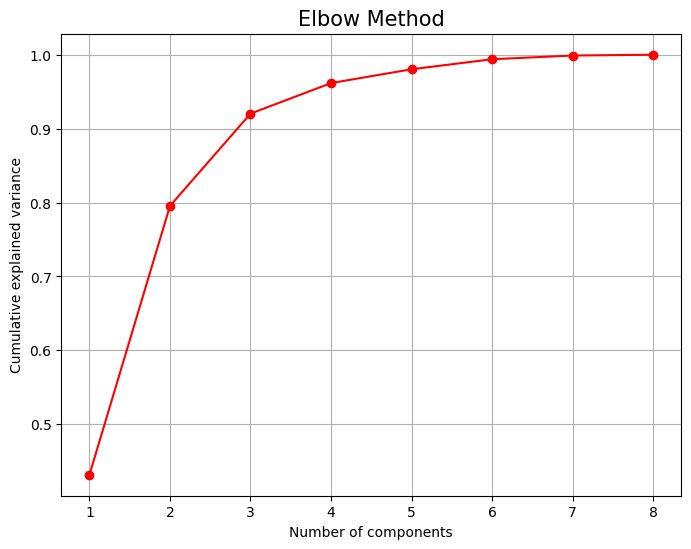

In [51]:
# Initialize the PCA
pca = PCA().fit(final_df_normalized)

# Create a list of explained variance ratios
explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Create a list of number of components
components = np.arange(1, len(explained_variance) + 1)

#Let's use a screeplot to visualize the number of features and the correspondend explained variance
plt.figure(figsize=(8, 6))
plt.plot(components, explained_variance, 'ro-')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.title('Elbow Method', fontsize = 15)
plt.grid()
plt.show()

The graph illustrates how the proportion of variance explained changes in relation to the number of principal components used.

Using the elbow method as a guide, it appears that three principal components would be the most optimal choice. This is because the proportion of variance explained continues to increase with the addition of more components, but the rate of increase becomes negligible after three components.

This suggests that three principal components are sufficient to capture a significant portion of the variance in the data, and further addition of components does not significantly enhance the explained variance.

\\
This choice is also supported by the "explained variance" result:

In [52]:
explained_variance = np.cumsum(pca.explained_variance_ratio_)
explained_variance

array([0.43162827, 0.79539598, 0.9202713 , 0.96160441, 0.98032678,
       0.99387943, 0.99892441, 1.        ])

> We can clearly see that five principal components are sufficient to explain 92% of the total variance in the data. Adding more components does not significantly increase the proportion of explained variance, indicating that the first three components capture a substantial portion of the variance in the data.

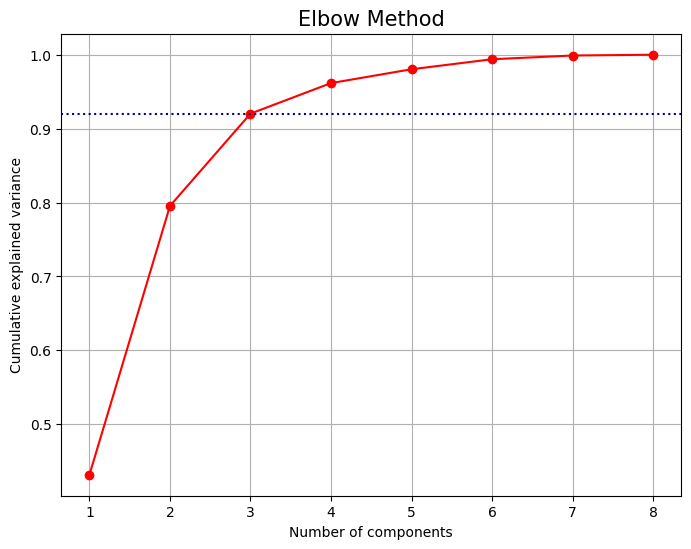

In [53]:
plt.figure(figsize=(8, 6))
plt.plot(components, explained_variance, 'ro-')
plt.axhline(y=0.92, color='darkblue', linestyle='dotted') #cumulative variance explained by 3 components
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.title('Elbow Method', fontsize = 15)
plt.grid()
plt.show()

A heatmap can provide a visual representation of the contribution of each feature to the PCA, which can be particularly useful for understanding the relationships between different features in the data.

\\
We decided to square the elements of the PCA matrix because it will make the larger ones more dominant and the smaller ones more negligible, which can help to highlight the patterns and clusters in the data. However, this also means that the original scale of the data is distorted, and we should keep it in mind while doing the interpretation.

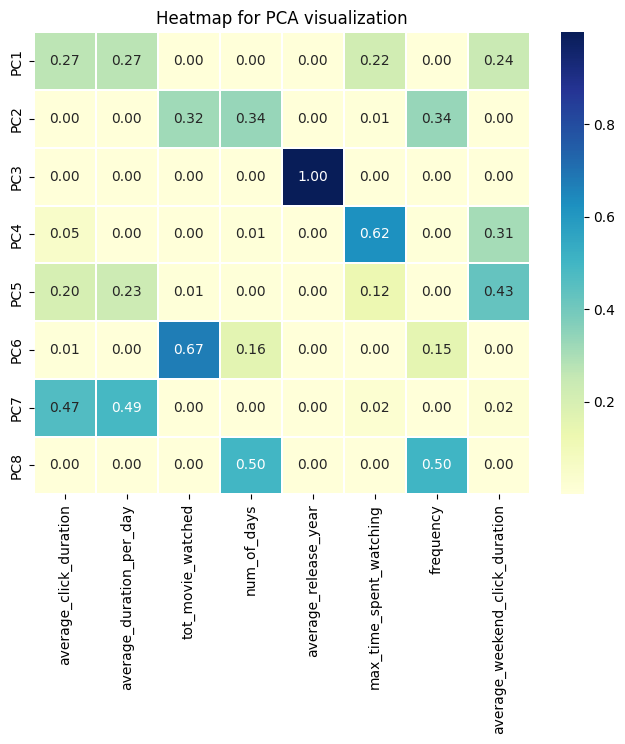

In [54]:
# Create a DataFrame from the components_ attribute
pca = PCA().fit(final_df_normalized)

# List of columns to be used for PCA
pca_columns = final_df_normalized.columns
#and we can extract the pca components ("pca.components_") from the previous performed pca

df_components = pd.DataFrame(pca.components_, columns=pca_columns)

# Create a heatmap
plt.figure(figsize=(8, 6))
ax = sns.heatmap(df_components**2, cmap='YlGnBu', annot=True, fmt='.2f', linewidths=0.1)
ax.set_yticklabels(['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8'])
plt.title("Heatmap for PCA visualization")
plt.show()


> From the heatmap we can observe that the first principal component explains the 27% of both the ***average click duration*** and the ***average duration per day***. It also explains 22% of ***max time spent watching*** and 24% of ***average weekend click duration***, basically all the columns that derive from the original **duration** variable. \\
The secodn principal component explains 32% of ***tot movie watched*** and 34% of both ***mun of days*** and ***frequency***.
 \\
 The third principal component entirely explains the ***average relase year***. \\
 We can see that there are no common variables whatsoever between the 3 main principal components.

## ***2.3 Clustering!***

1)  Implement the K-means clustering algorithm (**not** ++: random initialization) using MapReduce. We ask you to write the algorithm from scratch following what you learned in class.

2)  Find an optimal number of clusters. Use at least two different methods. If your algorithms provide diverse optimal K's, select one of them and explain why you chose it.

3)  Run the algorithm on the data obtained from the dimensionality reduction.

4)  Implement **K-means++** from scratch and explain the differences with the results you got earlier.

5)  Ask ChatGPT to recommend other clustering algorithms and choose one. Explain your choice, then ask ChatGPT to implement it or use already implemented versions (e.g., the one provided in the scikit-learn library) and run it on your data. Explain the differences (if there are any) in the results. Which one is the best, in your opinion, and why?

In [55]:
def initialize_centroids_random(data, k):
    return data.takeSample(False, k)


def assign_to_nearest_centroid(data, centroids):
    return data.map(
        lambda point: (
            np.argmin([np.linalg.norm(point - centroid) for centroid in centroids]),
            point,
        )
    )


def recompute_centroids(data_assigned):
    return (
        data_assigned.groupByKey()
        .mapValues(lambda points: np.mean(list(points), axis=0))
        .sortByKey()
        .values()
        .collect()
    )


def kmeans(data, k, centroid_init, max_iterations=100, tolerance=0.00001):
    # Function will be one of the parameters
    centroids = centroid_init(data, k)
    for _ in range(max_iterations):
        last_centroids = centroids

        # MapReduce Steps:
        # Map step: Assign each point to the nearest centroid
        assigned_data = assign_to_nearest_centroid(data, centroids)

        # Reduce step: Calculate new centroids
        centroids = recompute_centroids(assigned_data)

        # Check for convergence
        centroids_shift = sum(
            np.linalg.norm(np.array(centroid) - np.array(last_centroid))
            for centroid, last_centroid in zip(centroids, last_centroids)
        )
        if centroids_shift < tolerance:
            break

    return centroids


def kmeans_random(data, k, max_iterations=100, tolerance=0.00001):
    # Wrapper for kmeans random
    return kmeans(
        data,
        k,
        centroid_init=initialize_centroids_random,
        max_iterations=max_iterations,
        tolerance=tolerance,
    )

In [56]:
def calculate_SSE(data, centroids):
    return data.map(
        lambda point: min(
            np.linalg.norm(point - centroid) ** 2 for centroid in centroids
        )
    ).sum()


def silhouette_score(data, centroids):
    def compute_distances(point):
        distances = np.array(
            [np.linalg.norm(point - centroid) for centroid in centroids]
        )
        closest, second_closest = np.partition(distances, 1)[:2]
        return closest, second_closest

    scores = data.map(lambda point: compute_distances(point)).collect()
    a = np.mean([s[0] for s in scores])
    b = np.mean([s[1] for s in scores])
    return (b - a) / max(a, b)

Now we will convert the pd.dataframe we will put into the algorithm into a PySpark dataframe in order to use it. That's because some methods that work with PySpark dataframes don't work with Pandas dataframes

In [62]:
# Create a SparkSession
spark = SparkSession.builder.getOrCreate()

# Convert the pandas DataFrame to a PySpark DataFrame
df_spark = spark.createDataFrame(final_df_normalized)

In [63]:
type(df_spark)

pyspark.sql.dataframe.DataFrame

Let's write the spark dataframe to a csv file so that we can re-use it later more easly:

In [96]:
df_spark.write.csv("df_spark.csv", header=True, mode="overwrite")
#df_spark = pd.read_csv("df_spark.csv")

We can see that it's a PySpark dataframe so let's move forward

In [64]:
spark = SparkSession.builder.appName("K-means Clustering").getOrCreate()

# Loading data
data_spark = df_spark

# Feature names which will be used
feature_names = [
    "average_click_duration",
    "average_duration_per_day",
    "tot_movie_watched",
    "num_of_days",
    "average_release_year",
    "max_time_spent_watching",
    "frequency",
    "average_weekend_click_duration",
]

# Conversion to rdd
data_rdd = df_spark.rdd.map(lambda row: np.array([row[col] for col in feature_names]))

sse_list = []
silhouette_scores = []
for k in range(2, 15):
    centroids = kmeans_random(data_rdd, k)
    sse = calculate_SSE(data_rdd, centroids)
    score = silhouette_score(data_rdd, centroids)
    sse_list.append(sse)
    silhouette_scores.append(score)

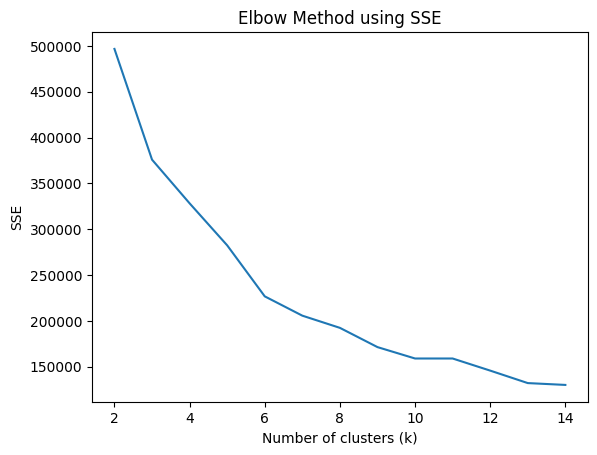

In [65]:
plt.plot(range(2, 15), sse_list)
plt.title("Elbow Method using SSE")
plt.xlabel("Number of clusters (k)")
plt.ylabel("SSE")
plt.show()

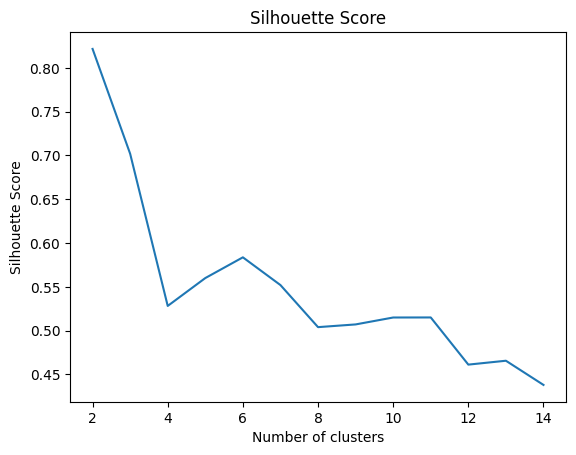

In [66]:
plt.plot(range(2, 15), silhouette_scores)
plt.title("Silhouette Score")
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette Score")
plt.show()

In [67]:
spark.stop()

In [68]:
def initialize_centroids_plusplus(data, k):
    centroids = [data.takeSample(False, 1)[0]]
    for _ in range(1, k):
        distances = data.map(
            lambda point: min(np.linalg.norm(point - centroid) ** 2 for centroid in centroids)
        ).collect()
        probabilities = [dist / sum(distances) for dist in distances]
        cumulative_probabilities = np.cumsum(probabilities)
        r = np.random.rand()
        for i, p in enumerate(cumulative_probabilities):
            if r < p:
                centroids.append(data.collect()[i])
                break
    return centroids

def kmeans_plusplus(data, k, max_iterations=100, tolerance=0.00001):
    return kmeans(
        data,
        k,
        centroid_init=initialize_centroids_plusplus,
        max_iterations=max_iterations,
        tolerance=tolerance,
    )


In [69]:
spark = SparkSession.builder.appName("K-means Clustering").getOrCreate()

# Loading data
data_spark =df_spark

# Feature names which will be used
feature_names = [
    "average_click_duration",
    "average_duration_per_day",
    "tot_movie_watched",
    "num_of_days",
    "average_release_year",
    "max_time_spent_watching",
    "frequency",
    "average_weekend_click_duration",
]

# Conversion to rdd
data_rdd = data_spark.rdd.map(lambda row: np.array([row[col] for col in feature_names]))

sse_list = []
silhouette_scores = []
for k in range(2, 5):
    print(k)
    centroids = kmeans_plusplus(data_rdd, k)
    print(k)
    sse = calculate_SSE(data_rdd, centroids)
    score = silhouette_score(data_rdd, centroids)
    sse_list.append(sse)
    silhouette_scores.append(score)

2


AttributeError: ignored

In [ ]:
plt.plot(range(2, 5), sse_list)
plt.title("Elbow Method using SSE")
plt.xlabel("Number of clusters (k)")
plt.ylabel("SSE")
plt.show()

In [ ]:
plt.plot(range(2, 5), silhouette_scores)
plt.title("Silhouette Score")
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette Score")
plt.show()

In [ ]:
spark.stop()

## ***2.4 Analysing your results!***

#####**2.2.1 & 2.2.2**

After analyzing out dataset we came to the conclusion that the variables that are relevant to identify the cluster of the customer are the following:

1. **average_click_duration**: This variable could be used to identify customers who are more or less engaged with the content. Customers with longer average click durations might be more engaged and could be targeted with different marketing strategies.

2. **tot_movie_watched**: This variable can provide insights into customer engagement levels. For example, customers with a high number of total movie watches might be more engaged and could be targeted with different marketing strategies.

3. **average_release_year**: Average release year of the movies each user has watched. Customers who watch movies from a specific time period might have similar interests, allowing you to create targeted marketing campaigns for customers with similar preferences.

These variables are commonly used in customer segmentation and could be used in a clustering algorithm to identify different customer groups

--------------------------------------------------------------------------------

After choosing the most relevant variables let's catgeorize them into 4 categories:

In [70]:
#Let's first create an empty dataframe where we will put the choosen variables
df_choosen = pd.DataFrame()

**Average click duration**

Now let's have a look at the maximum and minimum values that the variable takes, in order to decide the bins for the categorization:

In [71]:
avg_click_max = max(final_df['average_click_duration'])
avg_click_min = min(final_df['average_click_duration'])
print("The maixmum value for average clickd duration is "+ str(avg_click_max) + " and the minimum is " + str(avg_click_min))

The maixmum value for average clickd duration is 9106092.0 and the minimum is 0.0


Since the variable takes as the maximum value 9106092.0 and the minimum one is 0 we can categorize it as it follows:

In [72]:
# Considering the max and min values of the variable computed before, let's define the categories and the bins:
categories = ['0', '0-4553602.5', '4553602.5-6830403.75', ' 6830403.75-9106092.0']
bins = [0, 2276801.25, 4553602.5, 6830403.75, 9106092.0]

# Create a new column in your DataFrame to store the categories
df_choosen['average_click_duration'] = pd.cut(final_df['average_click_duration'], bins=bins, labels=False, include_lowest=True)
df_choosen

,average_click_duration
0,0
1,0
2,0
3,0
4,0
...,...
82376,0
82377,0
82378,0
82379,0


**Total movie watched**

In [73]:
#Let's have a look at total movie watched max and min values to decide how to categorize the variable:
tot_mov_min = min(final_df['tot_movie_watched'])
tot_mov_max = max(final_df['tot_movie_watched'])
print("The maixmum value for total movie watched is "+ str(tot_mov_max) + " and the minimum is " + str(tot_mov_min))

The maixmum value for total movie watched is 206 and the minimum is 1


In [74]:
#Now let's define the categories and the bins:
categories = ['1', '1-10', '10-50', '50-206']
bins = [1, 10, 50, 160, 206]

# Create a new column in your DataFrame to store the categories
df_choosen['tot_movie_watched'] = pd.cut(final_df['tot_movie_watched'], bins=bins, labels=False, include_lowest=True)
df_choosen

,average_click_duration,tot_movie_watched
0,0,1
1,0,0
2,0,0
3,0,0
4,0,1
...,...,...
82376,0,0
82377,0,0
82378,0,0
82379,0,0


**Average release year**

In [76]:
##Let's have a look at average release year max and min values to decide how to categorize the variable:
avg_release_min = min(final_df['average_release_year'])
avg_release_max = max(final_df['average_release_year'])
print("The maixmum value for average release year is "+ str(avg_release_max) + " and the minimum is " + str(avg_release_min))

The maixmum value for average release year is 2020 and the minimum is 1940


In [77]:
#Now let's define the categories and the bins:
categories = ['1940-1960', '1960-1980', '1980-2000', '2000-2020']
bins = [1940, 1960, 1980, 2000, 2020]

# Create a new column in your DataFrame to store the categories
df_choosen['average_release_year'] = pd.cut(final_df['average_release_year'], bins=bins, labels=False, include_lowest=True)
df_choosen

,average_click_duration,tot_movie_watched,average_release_year
0,0,1,3
1,0,0,3
2,0,0,3
3,0,0,3
4,0,1,3
...,...,...,...
82376,0,0,3
82377,0,0,3
82378,0,0,3
82379,0,0,3


In [78]:
#Let's check we don't have any NaN values
df_choosen.isna().sum()

average_click_duration    0
tot_movie_watched         0
average_release_year      0
dtype: int64

#####**2.4.3**

Now that we have the categorized variables we can perform the pivot tables.

> First we need to standardize the data we are going to work with, as it ensures that all variables are on the same scale, which can help the algorithm to find clusters that would otherwise be too small or too close together to detect. Therefore, it is generally a good idea to standardize the data before running K-means clustering (since we will need to run it on our selected variables for the clustering).

> We will then recall our kmeans function in order to perform the clustering, choosing for the optimal number of cluster k = 3. \\
After that we can move onto the pivot table.

In [79]:
# Select the 'total_movie_watched' and 'average_click_duration' columns from the DataFrame
columns_to_standardize = df_choosen[['tot_movie_watched', 'average_click_duration', 'average_release_year']]

# Reshape the selected data into a 2D array
reshaped_data = columns_to_standardize.values.reshape(-1, 3)

# Initialize a StandardScaler
scaler = StandardScaler()

# Fit the StandardScaler to the 2D array data
scaler.fit(reshaped_data)

# Transform the 2D array data using the StandardScaler
standardized_data = scaler.transform(reshaped_data)

# Convert the transformed data back to a pandas DataFrame
standardized_columns_df = pd.DataFrame(standardized_data, columns=columns_to_standardize.columns)

# Replace the original columns in the DataFrame with the standardized columns
df_choosen[['tot_movie_watched', 'average_click_duration','average_release_year']] = standardized_columns_df

Let's convert ou pd.dataframe to a PySpark dataframe for the same reason we explained in question 2.3:

In [80]:
# Create a SparkSession
spark = SparkSession.builder.getOrCreate()

# Convert the pandas DataFrame to a PySpark DataFrame
df_spark = spark.createDataFrame(df_choosen)

#
Rdd = df_spark.rdd.map(lambda row: np.array(row))

In [81]:
type(df_spark)

pyspark.sql.dataframe.DataFrame

Now we have a PySpark dataframe to which we can apply the kmeans

In [82]:
# Define the number of clusters.
k = 3

# Initialize the centroids randomly
centroids = initialize_centroids_random(Rdd, k)

# Run the K-means algorithm
cluster_centroids = kmeans_random(Rdd, k)

#assign each data point to its nearest cluster and compute the cluster centroids

# Map each data point to its nearest cluster
data_assigned = assign_to_nearest_centroid(Rdd, cluster_centroids)

# Recompute the cluster centroids
final_centroids = recompute_centroids(data_assigned)

In [83]:
# Create a new column in the DataFrame for the cluster assignments.
df_choosen['cluster'] = data_assigned.map(lambda point: point[0]).collect()
df_choosen

,average_click_duration,tot_movie_watched,average_release_year,cluster
0,-0.021864,3.438757,0.228621,1
1,-0.021864,-0.280743,0.228621,0
2,-0.021864,-0.280743,0.228621,0
3,-0.021864,-0.280743,0.228621,0
4,-0.021864,3.438757,0.228621,1
...,...,...,...,...
82376,-0.021864,-0.280743,0.228621,0
82377,-0.021864,-0.280743,0.228621,0
82378,-0.021864,-0.280743,0.228621,0
82379,-0.021864,-0.280743,0.228621,0


Now let's create the pivot tables:

> ##### **Average click duration**

In [84]:
# Define the categories and the bins
categories = ['0', '0-4553602.5', '4553602.5-6830403.75', ' 6830403.75-9106092.0']
bins = [0, 2276801.25, 4553602.5, 6830403.75, 9106092.0]

# Categorizing data into bins
df_choosen['click_duration_category'] = pd.cut(final_df['average_click_duration'], bins=bins, include_lowest=True, labels = categories)

# Create the pivot table
pivot_table_avg_click = pd.pivot_table(df_choosen, values='average_click_duration', index='cluster', columns='click_duration_category', aggfunc='count')
print(pivot_table_avg_click)

click_duration_category      0  0-4553602.5  4553602.5-6830403.75  \
cluster                                                             
0                        76221           40                     3   
1                         6116            0                     0   

click_duration_category   6830403.75-9106092.0  
cluster                                         
0                                            1  
1                                            0  


> #### **Total movie watched**

In [85]:
# Define the categories and the bins
categories = ['1', '1-10', '10-50', '50-206']
bins = [1, 10, 50, 160, 206]

df_choosen['tot_movie_category'] = pd.cut(final_df['tot_movie_watched'], bins=bins, include_lowest=True, labels = categories)

#Pivot table
pivot_table_tot_movie = pd.pivot_table(df_choosen, values='tot_movie_watched', index='cluster', columns='tot_movie_category', aggfunc='count')
print(pivot_table_tot_movie)

tot_movie_category      1  1-10  10-50  50-206
cluster                                       
0                   76265     0      0       0
1                       0  6015    100       1


> #### **Average release year**

In [86]:
# Define the categories and the bins
categories = ['1940-1960', '1960-1980', '1980-2000', '2000-2020']
bins = [1940, 1960, 1980, 2000, 2020]

df_choosen['release_year_category'] = pd.cut(final_df['average_release_year'], bins=bins, include_lowest=True, labels = categories)

#Pivot table
pivot_table_avg_release = pd.pivot_table(df_choosen, values='average_release_year', index='cluster', columns='release_year_category', aggfunc='count')
print(pivot_table_avg_release)

release_year_category  1940-1960  1960-1980  1980-2000  2000-2020
cluster                                                          
0                             29        427       3942      71867
1                              0          0         60       6056


Now let's compute the percentage by column for each pivot table. \\
We can see that the sum of each row (cluster) is 100:

In [87]:
pivot_table_avg_click_percentage = pivot_table_avg_click.div(pivot_table_avg_click.sum(axis=1), axis=0) * 100
print(pivot_table_avg_click_percentage)

click_duration_category           0  0-4553602.5  4553602.5-6830403.75  \
cluster                                                                  
0                         99.942306     0.052449              0.003934   
1                        100.000000     0.000000              0.000000   

click_duration_category   6830403.75-9106092.0  
cluster                                         
0                                     0.001311  
1                                     0.000000  


In [88]:
pivot_table_tot_movie_percentage = pivot_table_tot_movie.div(pivot_table_tot_movie.sum(axis=1), axis=0) * 100
print(pivot_table_tot_movie_percentage)

tot_movie_category      1       1-10     10-50    50-206
cluster                                                 
0                   100.0   0.000000  0.000000  0.000000
1                     0.0  98.348594  1.635056  0.016351


In [89]:
pivot_table_avg_release_percentage = pivot_table_avg_release.div(pivot_table_avg_release.sum(axis=1), axis=0) * 100
print(pivot_table_avg_release_percentage)

release_year_category  1940-1960  1960-1980  1980-2000  2000-2020
cluster                                                          
0                       0.038025    0.55989   5.168819  94.233266
1                       0.000000    0.00000   0.981033  99.018967


###**2.4.5**

**Interpretation of the results**

Based on the pivot tables we obtained, it appears that the majority of the movies are classified in the same cluster, while the remaining few movies are classified in a separate cluster.

In the 'pivot_table_avg_release', we can observe that most of the movies in Cluster 0 are from the 1980-2000 and 2000-2020 release year categories, while Cluster 1 has more movies from the 1940-1960 and 1960-1980 release year categories.

The 'pivot_table_avg_click_percentage' shows that Cluster 0 has a significantly higher click-through rate for all release year categories compared to Cluster 1. Cluster 1 also has a lower click-through rate for the 1980-2000 and 2000-2020 release year categories compared to Cluster 0.

In conclusion, the two clusters we obtained from the K-means clustering analysis are not well-separated. \\
In general, well-separated clusters are those where the data points in each cluster are far apart from the data points in the other clusters. In our case, it seems that the data points in each cluster are not far apart from the data points in the other clusters, which suggests that the clusters are not well-separated.

The differences in average release year and click-through rate between the two clusters might suggest potential marketing strategies for different types of movies

###**2.4.6**

To estimate clustering algorithm performance we decided to use the following metrics:
1. **Silhouette Score** \\
This metric measures how close each point in a cluster is to the points in the neighboring clusters. It ranges from -1 to 1, with a higher value indicating better-defined clusters. A score close to 1 suggests well-separated clusters. A score of 0 indicates that the sample is on or very close to the decision boundary between two neighboring clusters. Negative values, instead, indicate that those samples might have been assigned to the wrong cluster.

2. **Calinski-Harabasz Index** \\
Also known as the Variance Ratio Criterion, this score is defined as the ratio between the within-cluster dispersion and the between-cluster dispersion. It ranges from 0 to infinity, and an higher value suggests more distinct groups

Let's compute the choosen metrics and seee what they tell us about the clusters we obtained:

In [90]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score

#Let's compute the Silhouette score
features = df_choosen[["average_click_duration",	"tot_movie_watched",	"average_release_year"]]
predicted_clusters = df_choosen["cluster"]

shiluette_score = silhouette_score(features, predicted_clusters)
print('Shiluette Score:', shiluette_score)

Shiluette Score: 0.8977949667260358


In [91]:
#Now let's compute the Calinski-Harabasz_score
calinski_harabasz_score = calinski_harabasz_score(features, predicted_clusters)
print('Calinski-Harabasz Score:', calinski_harabasz_score)

Calinski-Harabasz Score: 40317.84333518047


> From both the Silhouette score and che Calinski-Harabasz_score we can see that the cluster that we created with the kmeans (random initialization) are well-separated and that the clustering method has resulted in a very high-quality clustering of the data. \\
These might be good results, but it's essential to keep in mind that the performance of the clustering method also depends on the number of clusters chosen and the specific requirements of the problem. This means that really good results (high scores), which is our case, could also mean that there might have been overfitting.